In [1]:
from qiskit import *
import numpy as np, matplotlib.pyplot as plt
from qiskit.tools.monitor import *
from qiskit.tools.visualization import plot_distribution

Grover's Algorithm can serve as a **quantum search algorithm** to find a marked item in an unsorted list, and runs on a quantum computer. It finds the unique input to a blackbox function that produces a particular output value, using just $O(\sqrt N)$ evaluations of the function, where $N$ is the size of the list.

It doesn't utilize the list's internal structure, and is therefore not useful for searching a sorted list. It is also not useful for searching a list of size N=2^n, as the list can be searched in O$(logN)$ time using a classical computer.

In [2]:
my_list = np.random.randint(0, 100, 100)
my_list

array([10, 95, 30, 10, 85, 66, 80,  4, 32, 31, 25, 86, 50, 62, 38, 44,  7,
       49, 78, 84, 63, 29, 72, 11, 97, 32, 17, 16, 19, 71, 72, 81, 34, 39,
       10, 24,  6, 47, 29, 75, 61, 44, 83, 64, 60, 72,  7, 45, 61,  6,  5,
       11, 11, 98,  3, 96, 25, 85,  7, 74, 47, 75, 54, 67, 19, 28, 69, 99,
       54, 37, 63, 93,  5, 33, 88, 80, 27, 70, 25, 41, 53, 53, 22, 74, 51,
        8, 95,  8, 99, 12, 68, 49, 77, 38, 41, 23, 18, 35,  1, 81])

Our goal is to locate a **random number** that you can choose and implement in  my code, that'll be present in this list. The Search Function ```oracle``` will do this for us:

In [3]:
def oracle(input):
    winner = 53 # CHANGE THIS AS YOU PLEASE
    
    if input == winner:
        return True
    else:
        return False

for index, trialnumber in enumerate(my_list):
    if oracle(trialnumber) == 1:
        print(f"Winner found at index {index} with value {trialnumber}")
        print(f"Total number of oracle trials: {index + 1}")
        
        break

Winner found at index 80 with value 53
Total number of oracle trials: 81


Defining the Oracle Quantum circuit:

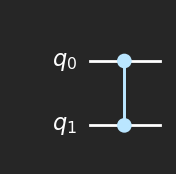

In [4]:
oracle_circuit = QuantumCircuit(2, name = 'Oracle')
oracle_circuit.cz(0, 1)
oracle_circuit.to_gate()

oracle_circuit.draw(output = 'mpl', style = 'iqx-dark')

And now the actual Grover's Circuit:

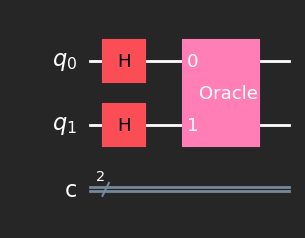

In [5]:
backend = Aer.get_backend('statevector_simulator')
grover = QuantumCircuit(2, 2)
grover.h([0, 1])
grover.append(oracle_circuit, [0, 1])

grover.draw(output = 'mpl', style = 'iqx-dark')

In [6]:
job = execute(grover, backend)
sv = job.result().get_statevector()
np.round(sv, 3)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

We can create a *Reflection Circuit* to amplify the amplitude of the marked state, and then apply the Grover's Circuit to the Oracle to get the final Grover's Circuit:

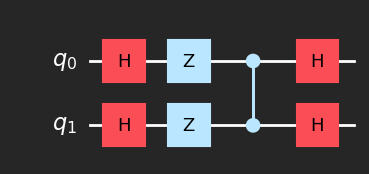

In [7]:
reflection = QuantumCircuit(2, name = 'Reflection')
reflection.h([0, 1])
reflection.z([0, 1])
reflection.cz(0, 1)
reflection.h([0, 1])
reflection.to_gate()

reflection.draw(output = 'mpl', style = 'iqx-dark')

Appending the Reflection Circuit to the Grover's Circuit:

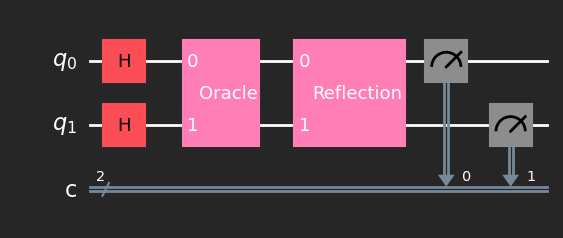

In [8]:
grover.append(reflection, [0, 1])
grover.measure([0, 1], [0, 1])

grover.draw(output = 'mpl', style = 'iqx-dark')

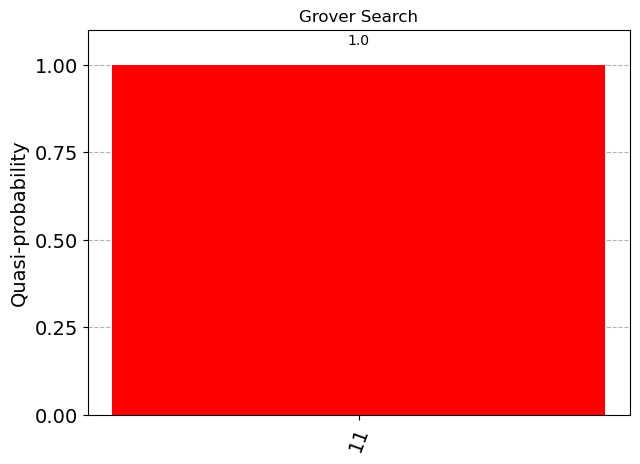

In [9]:
job = execute(grover, backend, shots = 1)
counts = job.result().get_counts()

plot_distribution(counts, title = 'Grover Search', color = 'red')

This visualization represents te **frequency of states** after each Grover's Iteration. The marked state will have a higher probability of being measured after each iteration, and the probability of measuring the marked state will increase with each iteration.

We now implement Grover's Algorithm on a real IBM Quantum Computer:

In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

C:\Users\DELL\AppData\Local\Temp\ipykernel_16748\3890573571.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
C:\Users\DELL\AppData\Local\Temp\ipykernel_16748\3890573571.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


We only used {'11': 1024} calls to the oracle to find the winner! Here, |11> is the winner state.


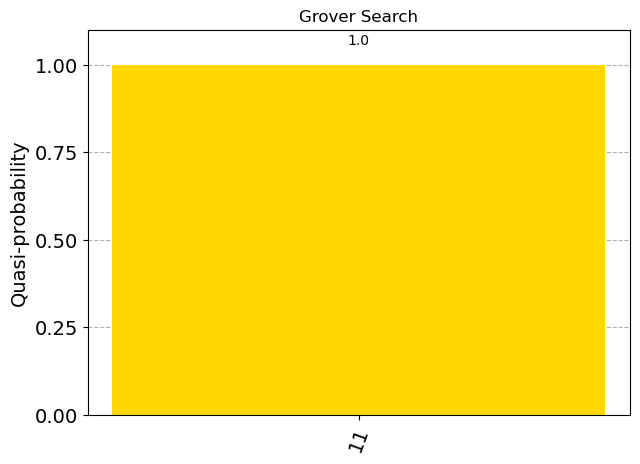

In [14]:
backend_qasm = provider.get_backend('ibmq_qasm_simulator')
job = execute(grover, backend_qasm, shots = 1024)
counts = job.result().get_counts()

print(f'We only used {counts} calls to the oracle to find the winner! Here, |11> is the winner state.')
plot_distribution(counts, title = 'Grover Search', color = 'gold')